# Load Packages

In [1]:
from scipy.misc import imread

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Declare Variables

In [2]:
# File path
usa_map_path = '../datasets/usamap.png'
usa_latlong_path = '../datasets/usa_latlong.txt'
usa_distance_path = '../datasets/usa_distances.txt'
usa_map_cities = '../datasets/usamap_cities.png'

# Map bounding box
usa_map_bb = [-129.46, 24.93, -66.00, 49.00]

# Load Dataset

In [3]:
img = imread(usa_map_path)
latlong = pd.read_csv(usa_latlong_path, sep='\t', index_col=0)
distance = pd.read_csv(usa_distance_path, sep='\t', index_col=0)

# From Distances to Coordinates

## Methods

In [4]:
def computeXXT(D):
    n= len(D)
    nssq= 0 
    sd2=0 
    MD2= np.zeros(n,dtype=np.int32)

    # COMPUTE MEAN SQUARE DISTANCES
    for i in range(n):
        sd2=0 
        for j in range(n): 
            sd2 += D[i,j]*D[i,j]
        MD2[i] = float(sd2)/n 
        nssq += sd2

    msq = nssq / (2*(n**2))

    # COMPUTE OUTER DIAGONALS
    XXT = np.zeros(D.shape, dtype=np.int32)
    for i in range(n):	
        for j in range(n): 
            XXT[j,i] = -0.5*(D[i,j]*D[i,j] - MD2[i] - MD2[j] + 2*msq)
    return XXT

In [5]:
def computeX(XXT, d):
    U, S, V = np.linalg.svd(XXT)
    # X = U[:,:d].dot(np.sqrt(S[:d]))
    n = len(XXT)
    X = np.zeros((n,d), dtype=np.int32)
    for i in range(n):
        for j in range(d):
            X[i,j] = U[i,j]*S[j]
    return X

## Calculate

In [6]:
XXT = computeXXT(distance.values)
# print(XXT)
X = computeX(XXT,2)

# From Coordinates to Lat-Long

## Methods

In [7]:
def normalize(A, origin='img'): 
    N = np.zeros(A.shape)
    min_x = np.zeros(A.shape[1])
    mean_x = np.zeros(A.shape[1])
    max_x = np.zeros(A.shape[1])
    for i in range(A.shape[1]):
        min_x[i] = np.min(A[:,i])
        mean_x[i] =np.mean(A[:,i]) 
        max_x[i] = np.max(A[:,i])
        if origin == 'img':
            N[:,i] = (A[:,i] + abs(min_x[i]))/ (max_x[i]+abs(min_x[i])-min_x[i])
        else: 
            N[:,i] = (A[:,i] - mean_x[i])/ (max_x[i]-min_x[i])
    return N, min_x, mean_x, max_x

## Preprocessing

In [8]:
# Normalize
X, min_x, mean_x, max_x = normalize(X, 'center')
ll, min_ll, mean_ll, max_ll = normalize(latlong.values, 'center')

# Unroll paramns
x = X[:,[0]]
y = X[:,[1]]

# Get size
n = x.shape

## Creating dataset

In [9]:
AX = np.concatenate((x, y, np.ones(n), np.zeros(n)), axis=1)
AY = np.concatenate((y, x, np.zeros(n), np.ones(n)), axis=1)
A = np.concatenate((AX,AY), axis=0)
b = np.concatenate((ll[:,1], ll[:,0]), axis=0)

# Learning Algorithms

For more info:
* https://math.stackexchange.com/questions/77462/finding-transformation-matrix-between-two-2d-coordinate-frames-pixel-plane-to
* http://nghiaho.com/?page_id=671

### Linear Regression (Estimation)

In [10]:
coord_to_latlong = np.linalg.lstsq(A, b)[0]

In [11]:
# Get theta-approximated
theta = np.arctan2(coord_to_latlong[1], coord_to_latlong[0])

# Update values
coord_to_latlong[0] = np.cos(theta)
coord_to_latlong[1] = np.sin(theta)

In [12]:
latlong_approx = np.dot(A,coord_to_latlong).reshape(X.shape, order='F')
latlong_approx = np.flip(latlong_approx, axis=1)
latlong_approx = (max_ll - min_ll) * latlong_approx + mean_ll

### Kabsch Algorithm (Exact)

# Result

## Geometric operations parameters

In [13]:
print('Rotation (anti-clockwise) = %f' % (360 * theta/(2 * np.pi),))
print('Translation (x axis) = %f' %(coord_to_latlong[2],))
print('Translation (y axis) = %f' %(coord_to_latlong[3],))

Rotation (anti-clockwise) = -179.541465
Translation (x axis) = 0.000000
Translation (y axis) = 0.000000


## Lat-Long

Can be plotted at: https://www.mapcustomizer.com/#

In [14]:
print('Original\n')
print(latlong.values)
print('\nEstimated\n')
print(latlong_approx)

Original

[[  42.3601  -71.0589]
 [  42.8864  -78.8784]
 [  41.8781  -87.6298]
 [  32.7767  -96.797 ]
 [  39.7392 -104.9903]
 [  29.7604  -95.3698]
 [  34.0522 -118.2437]
 [  35.1495  -90.049 ]
 [  25.7617  -80.1918]
 [  44.9778  -93.265 ]
 [  40.7128  -74.006 ]
 [  41.2524  -95.998 ]
 [  39.9526  -75.1652]
 [  33.4484 -112.074 ]
 [  40.4406  -79.9959]
 [  38.627   -90.1994]
 [  40.7608 -111.891 ]
 [  37.7749 -122.4194]
 [  47.6062 -122.3321]
 [  38.9072  -77.0369]]

Estimated

[[  43.676369    -71.91246053]
 [  42.81898475  -79.48588007]
 [  40.93467158  -87.79506308]
 [  32.03996587  -97.01018157]
 [  38.83162813 -105.20528815]
 [  29.22039982  -95.4074352 ]
 [  35.03436876 -120.34888068]
 [  34.45794108  -89.64180486]
 [  26.72889953  -77.16275549]
 [  43.58301368  -93.44603856]
 [  41.63170074  -74.1675991 ]
 [  40.01663533  -95.98602915]
 [  40.68331077  -75.04349484]
 [  33.56885583 -113.82841288]
 [  40.38739118  -79.98789251]
 [  37.72142901  -90.06657261]
 [  40.40353683 -111.

## Plot

In [15]:
def latlong_to_map(points, map_shape, bounding_box):
    # (0,0) is top-left corner
    y_inversion = np.array([-1, 1])
    y_translation = np.array([1, 0])

    # expanding variables
    height, width, _ = map_shape
    west, south, east, north = bounding_box
    
    # converting to numpy
    map_shape = np.array([height, width])
    southwest = np.array([south, west])
    northeast = np.array([north, east])
    
    # Normalization
    points = (points - southwest)/(northeast - southwest)
    
    # Inversion
    points = y_inversion * points + y_translation
    
    # Scaling to map coordinates
    points = map_shape * points
    
    # Longitude to x-axis and Latitude to y-axis
    return np.flip(points, axis=1)

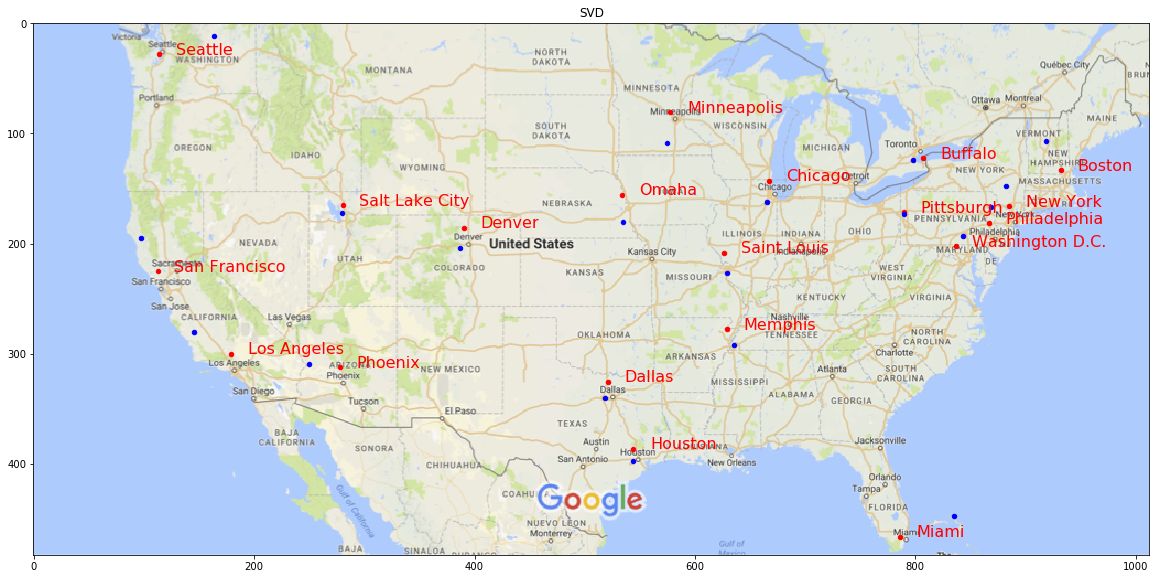

In [16]:
# Convert points
points = latlong_to_map(latlong.values, img.shape, usa_map_bb)
points_approx = latlong_to_map(latlong_approx, img.shape, usa_map_bb)

# Config
plt.figure(figsize=(20,10))
plt.title('SVD')

# Plot map and cities
plt.imshow(img)
plt.scatter(points[:,0], points[:,1], c='r', s=20)
plt.scatter(points_approx[:,0], points_approx[:,1], c='b', s=20)

# Label cities
for i, txt in enumerate(latlong.index):
    plt.annotate(txt, (points[i,0] + 15.0,points[i,1] - 0.0), fontsize=16, color='red')

# Save
plt.savefig(usa_map_cities, dpi=200, bbox_inches='tight')

# Show inline
plt.show()